# Toy example - Meta gradients

## Baseline - trying to minimize a loss function without meta gradients

In [ ]:
# Imports
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt


def get_targets(x):
    """Random function to learn."""
    return (10 + x ** 2).sum(axis=-1)

Text(0.5, 1.0, 'Loss')

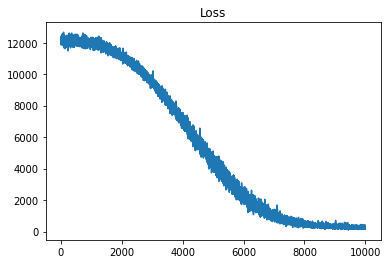

In [65]:
# Fix seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# Theta
model = nn.Sequential(
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 1))

# Loss to minimize
criterion = nn.MSELoss(reduction='none')

# Otimizer
opt  = optim.Adam(model.parameters(), lr=1e-4)

loss_data = [] # to plot loss values
for e in range(10000):
    
    # Get data
    x = torch.randn(32, 10)
    
    # Get Targets
    y = get_targets(x)
  
    # Predict targets with model - forward pass
    output = model(x)
    
    # Compute loss
    loss = criterion(output.squeeze(1), y).mean()
    loss_data.append(loss.item())
    
    # Backward pass
    opt.zero_grad()
    loss.backward()
    opt.step() 

# Plot loss
plt.figure()
plt.plot(loss_data)
plt.title("Loss")

## Adding a non learnable meta-parameter

Text(0.5, 1.0, 'Loss')

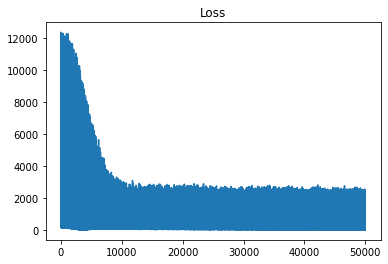

In [63]:
"""
when computing the loss, we will randomly add the term - meta_parameter * torch.rand(1)

The initial value for the meta_parameter is -100 and we make it a non trainable parmeter.

That should prevent the model from learning the function accurately.
"""

# Fix seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# Theta
model = nn.Sequential(
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 1))

# Meta parameter
meta_parameter = nn.Parameter(- 100 * torch.ones(1), requires_grad=False)

# Loss to minimize
criterion = nn.MSELoss(reduction='none')

# Otimizer
opt  = optim.Adam(model.parameters(), lr=1e-4)

loss_data = [] # to plot loss values
for e in range(50000):
    
    # Get data
    x = torch.randn(32, 10)
    
    # Get Targets
    y = get_targets(x)
  
    # Predict targets with model - forward pass
    output = model(x)
    
    # Compute loss - we randomly add a term between 0 and meta_parameter, 
    # preventing the model to learn the function accurately
    loss = criterion(output.squeeze(1), y + meta_parameter * torch.rand(1)).mean()
    loss_data.append(loss.item())
    
    # Backward pass
    opt.zero_grad()
    loss.backward()
    opt.step() 

# Plot loss
plt.figure()
plt.plot(loss_data)
plt.title("Loss")

## Meta gradients


Text(0.5, 1.0, 'Meta parameter')

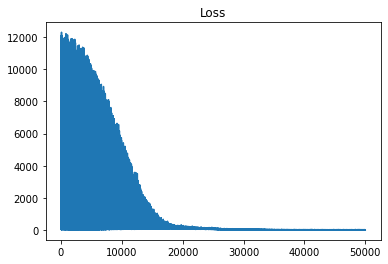

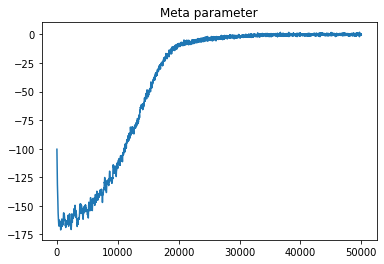

In [71]:
"""
when computing the loss, we will randomly add the term - meta_parameter * torch.rand(1)

The initial value for the meta_parameter is -100 but we make it a trainable parmeter.

The meta gradient should learn that in order to keep decreasing the loss function,
meta_parameter should be 0.0.3 
"""

# Theta
model = nn.Sequential(
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 1))

meta_parameter = torch.tensor(data=[-100], dtype=torch.float32, requires_grad=True)

criterion = nn.MSELoss(reduction='none')
meta_opt = optim.Adam([meta_parameter], lr=5e-1)
opt  = optim.Adam(model.parameters(), lr=1e-4)
loss_data = []
meta_paramater_data = []

for e in range(50000):
    
    # Get data
    x = torch.randn(32, 10)
    
    # Get Targets
    y = get_targets(x)
  
    # Predict targets with model - forward pass
    output = model(x)
    
    # Compute loss
    loss = criterion(output.squeeze(1), y + meta_parameter * torch.rand(1)).mean()
    loss_data.append(loss.item())

    # Clearn grads from previous iteration in both optimizers
    opt.zero_grad()
    meta_opt.zero_grad()

    # Backward pass
    loss.backward()
    opt.step() # theta' = theta + f(weights)

    # Meta forward pass
    output = model(x) # y = model(theta', x)

    # Meta loss - which loss is correct here? should this one as only accounts for normal loss
    meta_loss = criterion(output.squeeze(1), y).mean()

    # Meta backward pass  
    meta_loss.backward()
    meta_opt.step()
    meta_paramater_data.append(meta_parameter.item())
  
# Plot loss
plt.figure()
plt.plot(loss_data)
plt.title("Loss")
plt.figure()
plt.plot(meta_paramater_data)
plt.title("Meta parameter")